In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import re

## Read weekly data

In [2]:
start_date = date(2021, 10 ,27)
raw_data = pd.read_csv("weekly/evaluation_{}.csv".format(start_date.strftime("%Y%m%d")))

In [3]:
new_date = start_date
while True:
    new_date = new_date + timedelta(7)
    try:
        raw_data = raw_data.append(pd.read_csv("weekly/evaluation_{}.csv".format(new_date.strftime("%Y%m%d"))))
    except:
        break

In [4]:
raw_data

model       target  horizon forecast_date    q0.025  \
0       GeneralGrievous          DAX    1 day    2021-10-27 -2.950348   
1             AryaStark          DAX    1 day    2021-10-27 -2.294067   
2              DougJudy          DAX    1 day    2021-10-27  0.098211   
3           GinaLinetti          DAX    1 day    2021-10-27 -5.687000   
4    CaptainRaymondHolt          DAX    1 day    2021-10-27 -2.502641   
..                  ...          ...      ...           ...       ...   
415         GinaLinetti  temperature  84 hour    2021-12-22       NaN   
416        JabbaTheHutt  temperature  84 hour    2021-12-22       NaN   
417          RossGeller  temperature  84 hour    2021-12-22       NaN   
418      wind_benchmark  temperature  84 hour    2021-12-22       NaN   
419           wind_EMOS  temperature  84 hour    2021-12-22       NaN   

        q0.25      q0.5     q0.75    q0.975     value  qscore_q0.025  \
0   -1.095254 -0.121883  0.851487  2.706582 -0.060375       0.144499   
1   -0.422822  0.051950  0.540928  2.105637 -0.060375       0.111685   
2    0.098224  0.098231  0.098238  0.098250 -0.060375       0.309243   
3   -5.232000 -4.730000 -3.767000 -2.658000 -0.060375       0.281331   
4   -0.423577  0.075881  0.674492  2.657910 -0.060375       0.122113   
..        ...       ...       ...       ...       ...            ...   
415       NaN       NaN       NaN       NaN       NaN            NaN   
416       NaN       NaN       NaN       NaN       NaN            NaN   
417       NaN       NaN       NaN       NaN       NaN            NaN   
418       NaN       NaN       NaN       NaN       NaN            NaN   
419       NaN       NaN       NaN       NaN       NaN            NaN   

     qscore_q0.25  qscore_q0.5  qscore_q0.75  qscore_q0.975  mean_qscore  \
0        0.517439     0.061509      0.455931       0.138348     0.263545   
1        0.181223     0.112325      0.300651       0.108301     0.162837   
2        0.237898     0.158606      0.079306       0.007931     0.158597   
3        2.585813     4.669625      5.559938       5.065369     3.632415   
4        0.181601     0.136255      0.367433       0.135914     0.188664   
..            ...          ...           ...            ...          ...   
415           NaN          NaN           NaN            NaN          NaN   
416           NaN          NaN           NaN            NaN          NaN   
417           NaN          NaN           NaN            NaN          NaN   
418           NaN          NaN           NaN            NaN          NaN   
419           NaN          NaN           NaN            NaN          NaN   

           ae interval_coverage_0.5 interval_coverage_0.95 scores_imputed  
0    0.061509                  True                   True            NaN  
1    0.112325                  True                   True            NaN  
2    0.158606                 False                  False            NaN  
3    4.669625                 False                  False            NaN  
4    0.136255                  True                   True            NaN  
..        ...                   ...                    ...            ...  
415       NaN                 False                  False           True  
416       NaN                 False                  False           True  
417       NaN                 False                  False           True  
418       NaN                 False                  False           True  
419       NaN                 False                  False           True  

[3453 rows x 20 columns]

## Filter data

In [5]:
data = raw_data.loc[raw_data["model"] == "HanSolo"]
data["horizon"] = data["horizon"].apply(lambda x: re.findall(r'\d+', x)[0])
data = data.astype({"horizon":"float64"})
data["forecast_date"] = pd.to_datetime(data["forecast_date"])
data = data.reset_index().drop("index", axis = 1)

C:\Users\chris\AppData\Local\Temp/ipykernel_13212/3892431281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["horizon"] = data["horizon"].apply(lambda x: re.findall(r'\d+', x)[0])


# Dax evaluation

In [6]:
dax_data = data[data["target"] == "DAX"].copy()

In [7]:
for horizon in dax_data["horizon"].unique():
    dax_data.loc[dax_data["horizon"] == horizon, "forecast_date"] = dax_data.loc[dax_data["horizon"] == horizon, "forecast_date"] + timedelta(horizon)

In [9]:
def get_interval_plot(data):
    fig, axs = plt.subplots(figsize = (10,8))
    sns.lineplot(x = "forecast_date", y = "value", data = data, label = "True value")
    sns.lineplot(x = "forecast_date", y = "q0.5", data = data, label = "50% quantile")
    sns.lineplot(x = "forecast_date", y = "q0.025", data = data, color = "blue", label = "95% interval")
    sns.lineplot(x = "forecast_date", y = "q0.975", data = data, color = "blue")
    axs.fill_between(x = data["forecast_date"], y1 = data["q0.025"], y2 = data["q0.975"], alpha = 0.1, color = "blue")

    sns.lineplot(x = "forecast_date", y = "q0.25", data = data, color = "green", label = "50% interval")
    sns.lineplot(x = "forecast_date", y = "q0.75", data = data, color = "green")
    axs.fill_between(x = data["forecast_date"], y1 = data["q0.25"], y2 = data["q0.75"], alpha = 0.1, color = "green")
    axs.legend()

In [10]:
def get_error_plot(data, per_horizon=False):
    fig, axs = plt.subplots(figsize = (10,8))
    if per_horizon == False:
        sns.lineplot(x = "forecast_date", y = "mean_qscore", data = data)
    else:
        sns.lineplot(x = "forecast_date", y = "mean_qscore", hue = "horizon", data = data)

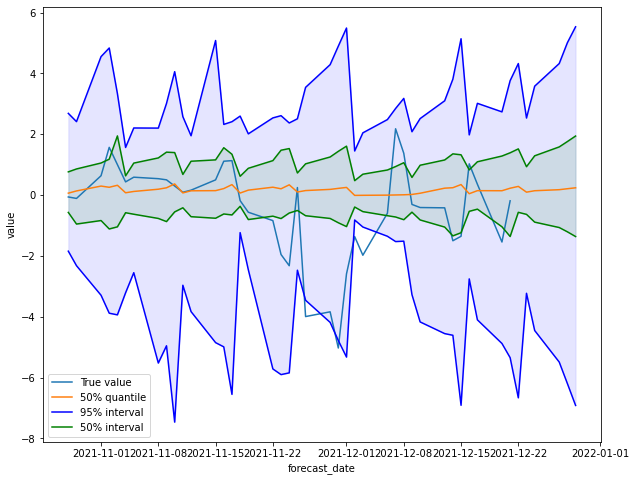

In [11]:
get_interval_plot(dax_data)

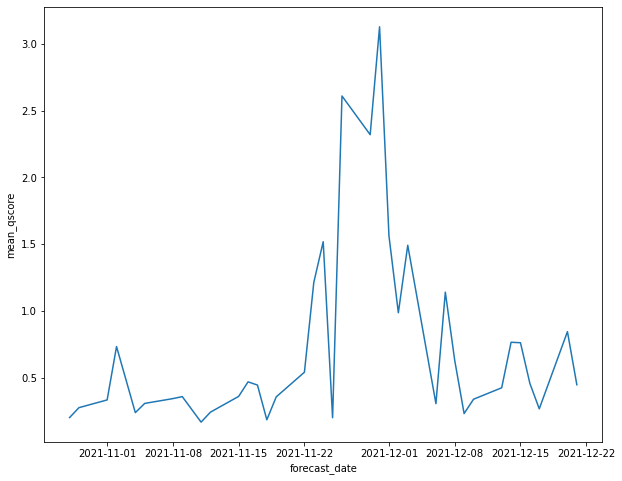

In [12]:
get_error_plot(dax_data)

# Wind evaluation

In [14]:
wind_data = data[data["target"] == "wind"].copy()
for horizon in wind_data["horizon"].unique():
    wind_data.loc[wind_data["horizon"] == horizon, "forecast_date"] = wind_data.loc[wind_data["horizon"] == horizon, "forecast_date"] + timedelta(hours = horizon)

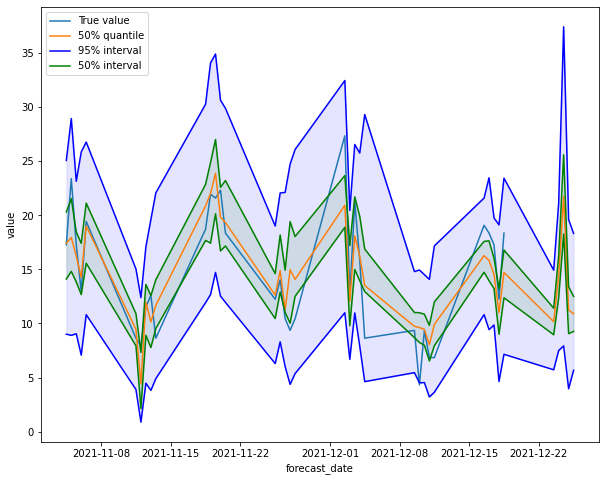

In [15]:
get_interval_plot(wind_data)

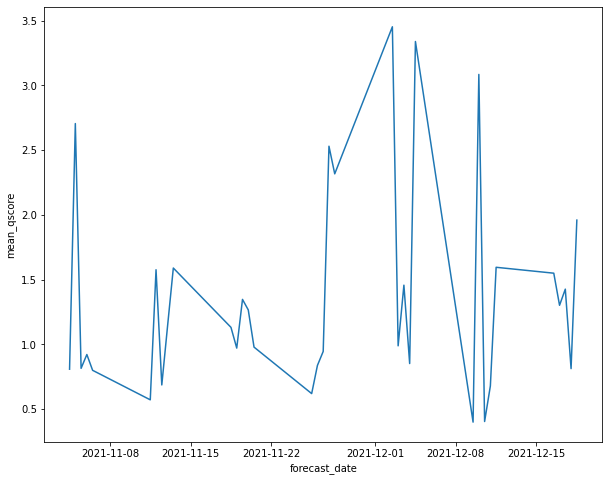

In [16]:
get_error_plot(wind_data)

# Temperature evaluation

In [17]:
temp_data = data[data["target"] == "temperature"].copy()
for horizon in temp_data["horizon"].unique():
    temp_data.loc[temp_data["horizon"] == horizon, "forecast_date"] = temp_data.loc[temp_data["horizon"] == horizon, "forecast_date"] + timedelta(hours = horizon)

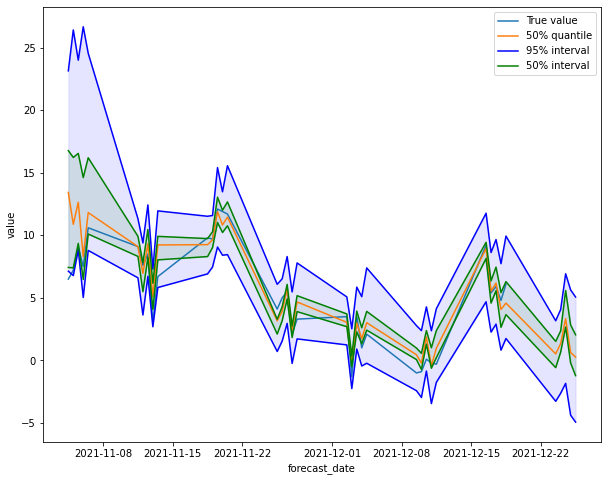

In [18]:
get_interval_plot(temp_data)

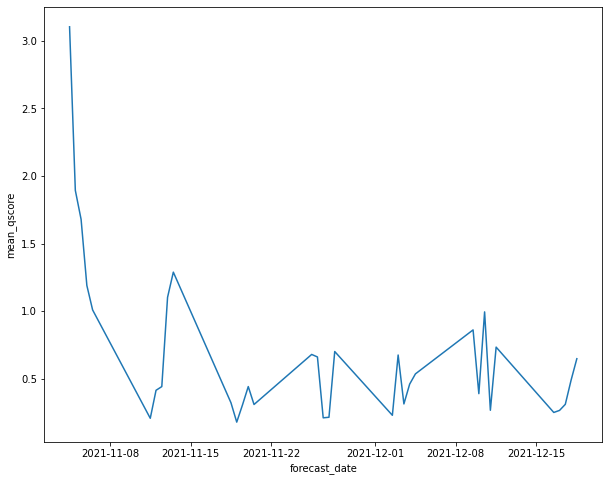

In [19]:
get_error_plot(temp_data)